### Load libraries

In [2]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

### Data Source

Loprinzi CL. Laurie JA. Wieand HS. Krook JE. Novotny PJ. Kugler JW. Bartel J. Law M. Bateman M. Klatt NE. et al. Prospective evaluation of prognostic variables from patient-completed questionnaires. North Central Cancer Treatment Group. Journal of Clinical Oncology. 12(3):601-7, 1994.

In [3]:
data = pd.read_csv("../Datasets/lung.csv", index_col = 0)
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
inst,,,,,,,,,
3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


In [4]:
data.shape

(228, 9)

### Variable description
* inst: Institution code
* time: Survival time in days
* status: censoring status 0 = censored, 1 = dead
* age: Age in years
* sex: Male = 0 Female = 1
* ph.ecog: ECOG performance score as rated by the physician. 0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed <50% of the day, 3 = in bed > 50% of the day but not bedbound, 4 = bedbound
* ph.karno: Karnofsky performance score (bad=0-good=100) rated by physician
* pat.karno: Karnofsky performance score as rated by patient
* meal.cal = Calories consumed at meals
* wt.loss = Weight loss in last six months


In [5]:
data = data[['time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno','pat.karno', 'meal.cal', 'wt.loss']]
data["status"] = data["status"] - 1
data["sex"] = data["sex"] - 1
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
inst,,,,,,,,,
3.0,306,0,74,0,1.0,90.0,100.0,1175.0,NaN
3.0,455,0,68,0,0.0,90.0,90.0,1225.0,15.0
3.0,1010,-1,56,0,0.0,90.0,90.0,NaN,15.0
5.0,210,0,57,0,1.0,90.0,60.0,1150.0,11.0
1.0,883,0,60,0,0.0,100.0,90.0,NaN,0.0


In [6]:
data.dtypes

time           int64
status         int64
age            int64
sex            int64
ph.ecog      float64
ph.karno     float64
pat.karno    float64
meal.cal     float64
wt.loss      float64
dtype: object

In [7]:
data.isnull().sum()

time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64

In [8]:
data.columns

Index(['time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno',
       'meal.cal', 'wt.loss'],
      dtype='object')

In [13]:
data["ph.karno"] = data["ph.karno"].fillna(data["ph.karno"].mean())
data["pat.karno"] = data["pat.karno"].fillna(data["pat.karno"].mean())
data["meal.cal"]= data["meal.cal"].fillna(data["meal.cal"].mean())
data["wt.loss"] = data["wt.loss"].fillna(data["wt.loss"].mean())
data.dropna(inplace=True)
data["ph.ecog"] = data["ph.ecog"].astype("int64")

In [14]:
data.isnull().sum()

time         0
status       0
age          0
sex          0
ph.ecog      0
ph.karno     0
pat.karno    0
meal.cal     0
wt.loss      0
dtype: int64

In [15]:
data.shape

(227, 9)

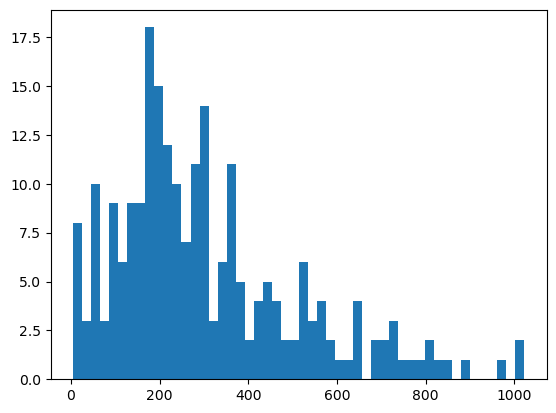

In [16]:
T = data["time"]
E = data["status"]
plt.hist(T, bins = 50)
plt.show()

## Fitting a non-parametric model [Kaplan Meier Curve]

<Axes: xlabel='timeline'>

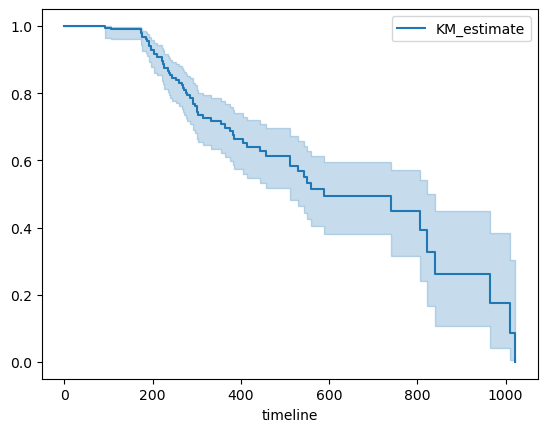

In [17]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

Text(0.5, 1.0, 'Survival function')

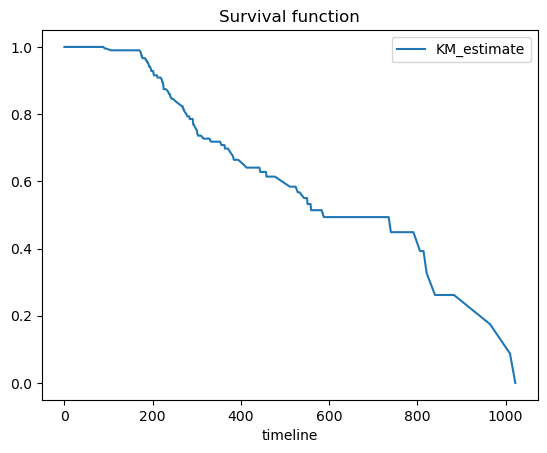

In [18]:
kmf.survival_function_.plot()
plt.title('Survival function')

<Axes: xlabel='timeline'>

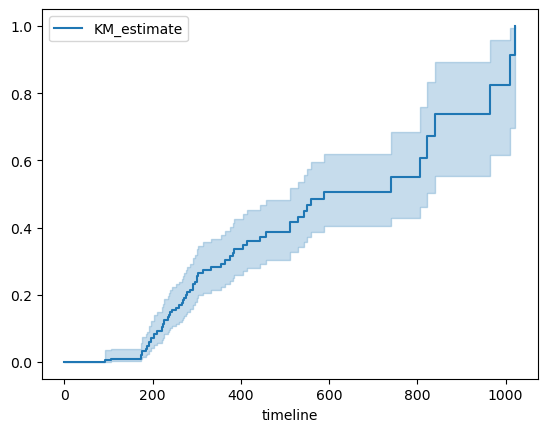

In [19]:
kmf.plot_cumulative_density()

In [20]:
kmf.median_survival_time_

np.float64(588.0)

In [21]:
from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

588.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   511.0                   821.0


Text(0.5, 1.0, 'Survival of different gender group')

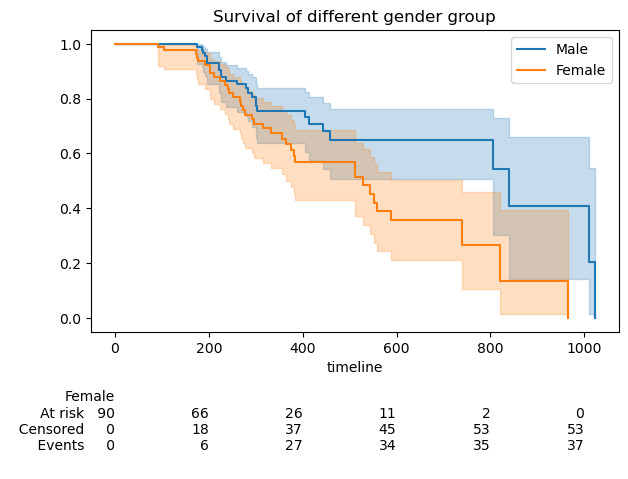

In [22]:
ax = plt.subplot(111)

m = (data["sex"] == 0)

kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)

plt.title("Survival of different gender group")

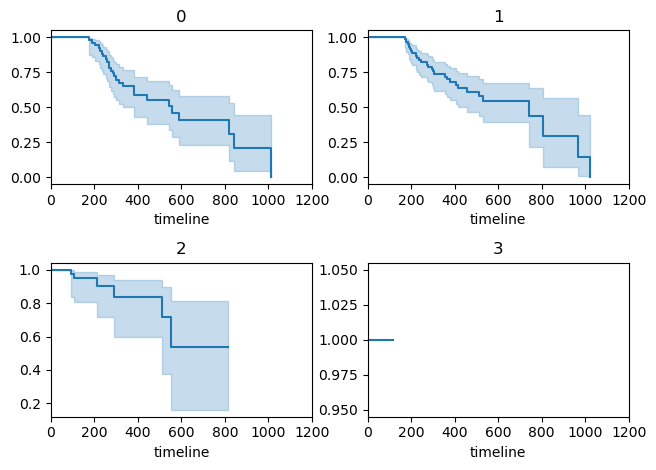

In [23]:
ecog_types = data.sort_values(by = ['ph.ecog'])["ph.ecog"].unique()

for i, ecog_types in enumerate(ecog_types):
    ax = plt.subplot(2, 2, i + 1)
    ix = data['ph.ecog'] == ecog_types
    kmf.fit(T[ix], E[ix], label = ecog_types)
    kmf.plot_survival_function(ax = ax, legend = False)
    plt.title(ecog_types)
    plt.xlim(0, 1200)

plt.tight_layout()

In [24]:
data['ph.ecog'].value_counts()

ph.ecog
1    113
0     63
2     50
3      1
Name: count, dtype: int64

In [25]:
data = data[data["ph.ecog"] != 3]
data.shape

(226, 9)

In [26]:
data['ph.ecog'].value_counts()

ph.ecog
1    113
0     63
2     50
Name: count, dtype: int64

## Fitting Cox Proportional Hazard Model

The Cox proportional hazards model, by contrast, is not a fully parametric model. Rather it is a semi-parametric model because even if the regression parameters (the betas) are known, the distribution of the outcome remains unknown.

[Cox Proportional Hazard Model (lifelines webpage)](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)

Cox proportional hazards regression model assumptions includes:

* Independence of survival times between distinct individuals in the sample,
* A multiplicative relationship between the predictors and the hazard, and
* A constant hazard ratio over time. This assumption implies that, the hazard curves for the groups should be proportional and cannot cross.

### Hazard and Hazard Ratio

* Hazard is defined as the slope of the survival curve — a measure of how rapidly subjects are dying.
* The hazard ratio compares two treatments. If the hazard ratio is 2.0, then the rate of deaths in one treatment group is twice the rate in the other group.

In [27]:
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
inst,,,,,,,,,
3.0,306,0,74,0,1,90.0,100.0,1175.000000,9.831776
3.0,455,0,68,0,0,90.0,90.0,1225.000000,15.000000
3.0,1010,-1,56,0,0,90.0,90.0,928.779006,15.000000
5.0,210,0,57,0,1,90.0,60.0,1150.000000,11.000000
1.0,883,0,60,0,0,100.0,90.0,928.779006,0.000000


In [28]:
dummies_ecog = pd.get_dummies(data["ph.ecog"],
                         prefix = 'ecog')
dummies_ecog.head(4)

,ecog_0,ecog_1,ecog_2
inst,,,
3.0,False,True,False
3.0,True,False,False
3.0,True,False,False
5.0,False,True,False


In [29]:
dummies_ecog = dummies_ecog[["ecog_1", "ecog_2"]]
data = pd.concat([data, dummies_ecog], 
                  axis = 1)
data.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
inst,,,,,,,,,,,
3.0,306,0,74,0,1,90.0,100.0,1175.000000,9.831776,True,False
3.0,455,0,68,0,0,90.0,90.0,1225.000000,15.000000,False,False
3.0,1010,-1,56,0,0,90.0,90.0,928.779006,15.000000,False,False
5.0,210,0,57,0,1,90.0,60.0,1150.000000,11.000000,True,False
1.0,883,0,60,0,0,100.0,90.0,928.779006,0.000000,False,False


In [30]:
data = data.drop("ph.ecog", axis = 1)
data.head()

,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
inst,,,,,,,,,,
3.0,306,0,74,0,90.0,100.0,1175.000000,9.831776,True,False
3.0,455,0,68,0,90.0,90.0,1225.000000,15.000000,False,False
3.0,1010,-1,56,0,90.0,90.0,928.779006,15.000000,False,False
5.0,210,0,57,0,90.0,60.0,1150.000000,11.000000,True,False
1.0,883,0,60,0,100.0,90.0,928.779006,0.000000,False,False


In [31]:
cph = CoxPHFitter()
cph.fit(data, duration_col = 'time', event_col = 'status')

cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 226 total observations, 163 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 226
number of events observed = 63
   partial log-likelihood = -257.92
         time fit was run = 2025-03-23 20:07:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.02      0.98      0.02           -0.05            0.01                0.95                1.01
sex        0.61      1.83      0.27            0.08            1.14                1.08                3.11
ph.karno   0.02      1.02      0.02           -0.02            0.06                0.98                1.06
pat.karno -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
meal.cal  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss   -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
ecog_1     0.05      1.06      0.37           -0.67            0.77                0.51                2.17
ecog_2     0.05      1.05      0.72           -1.36            1.46                0.26                4.30

           cmp to     z    p  -log2(p)
covariate                             
age          0.00 -1.33 0.18      2.46
sex          0.00  2.24 0.03      5.32
ph.karno     0.00  1.03 0.30      1.73
pat.karno    0.00 -0.26 0.79      0.34
meal.cal     0.00 -0.52 0.60      0.73
wt.loss      0.00 -0.17 0.87      0.21
ecog_1       0.00  0.15 0.88      0.18
ecog_2       0.00  0.07 0.94      0.08
---
Concordance = 0.47
Partial AIC = 531.85
log-likelihood ratio test = 11.60 on 8 df
-log2(p) of ll-ratio test = 2.56

### Interpretation

* Wt.loss has a coefficient of about -0.01.

* We can recall that in the Cox proportional hazard model, a higher hazard means more at risk of the event occurring.
The value $exp(-0.01)$ is called the hazard ratio.

* Here, a one unit increase in wt loss means the baseline hazard will increase by a factor 
of $exp(-0.01)$ = 0.99 -> about a 1% decrease. 

* Similarly, the values in the ecog column are: \[0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed $<$50\% of the day\]. The value of the coefficient associated with ecog2, $exp(1.20)$, is the value of ratio of hazards associated with being "in bed $<$50% of the day (coded as 2)" compared to asymptomatic (coded as 0, base category).

<Axes: xlabel='log(HR) (95% CI)'>

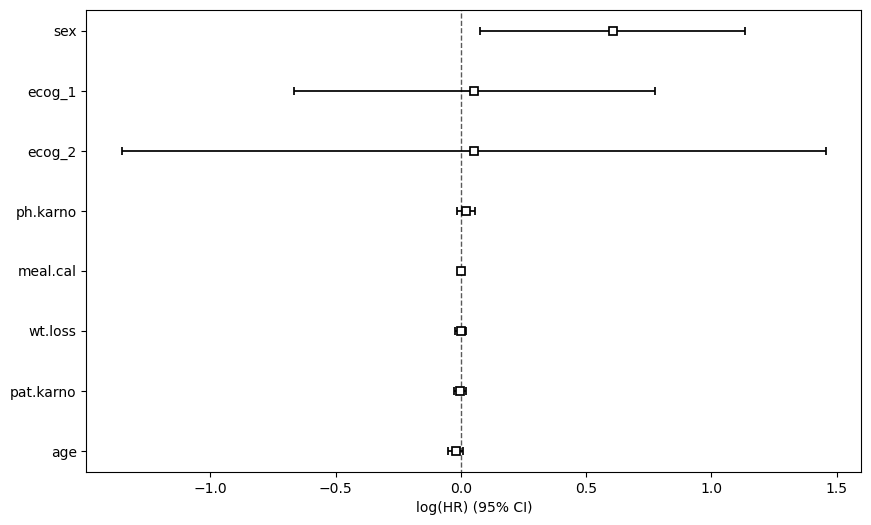

In [32]:
plt.subplots(figsize=(10, 6))
cph.plot()

<Axes: >

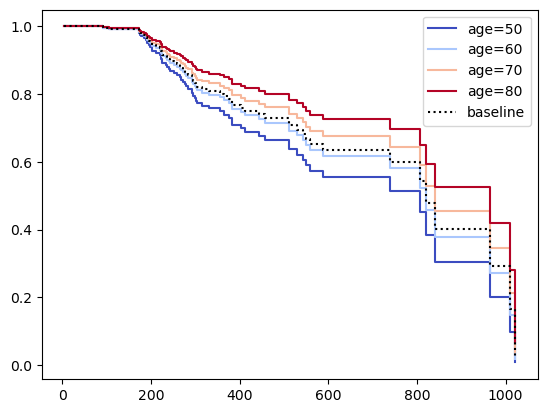

In [33]:
cph.plot_partial_effects_on_outcome(covariates = 'age',
                                    values = [50, 60, 70, 80],
                                    cmap = 'coolwarm')

In [34]:
cph.check_assumptions(data, p_value_threshold = 0.05)

IndexError: `training_df` index should be unique for this exercise. Please make it unique or use `.reset_index(drop=True)` to force a unique index

In [35]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 226 total observations, 163 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
age                  0.66 0.42      1.26
ecog_1               0.11 0.74      0.44
ecog_2               0.06 0.81      0.30
meal.cal             3.77 0.05      4.26
pat.karno            0.00 0.98      0.04
ph.karno             0.47 0.50      1.01
sex                  0.61 0.43      1.20
wt.loss              2.76 0.10      3.37

## Parametric [Accelerated Failure Time Model (AFT)]

[AFT Lifelines package webpage](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#accelerated-failure-time-models)

In [36]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter


# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
  model.fit(durations = data["time"],
            event_observed = data["status"])
  # Print AIC
  print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 970.9877884944783
The AIC value for ExponentialFitter is 1010.5751969715838
The AIC value for LogNormalFitter is 961.1168967053404
The AIC value for LogLogisticFitter is 967.5671666134224


### Fit the weibull fitter and print summary

In [37]:
from lifelines import WeibullAFTFitter
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data, duration_col='time', event_col='status')

weibull_aft.print_summary(3)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


ValueError: cannot reindex on an axis with duplicate labels

## Interpretation of the coefficients

* A unit increase in $x_i$ means the average/median survival time changes by a factor of $exp(b_i)$.
* Suppose $b_i$ was positive, then the factor $exp(b_i)$ is greater than 1, which will decelerate the event time since we divide time by the factor ⇿ increase mean/median survival. Hence, it will be a protective effect.
* Likewise, a negative $b_i$ will hasten the event time ⇿ reduce the mean/median survival time.
* This interpretation is opposite of how the sign influences event times in the Cox model!

## Example 

* Sex, which contains [0: Male and 1: Female], has a positive coefficient. 
* This means being a female subject compared to male changes mean/median survival time by exp(0.416) = 1.516,  approximately a 52% increase in mean/median survival time.

In [136]:
print(weibull_aft.median_survival_time_)
print(weibull_aft.mean_survival_time_)

419.09746495651444
495.9697546642166


<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

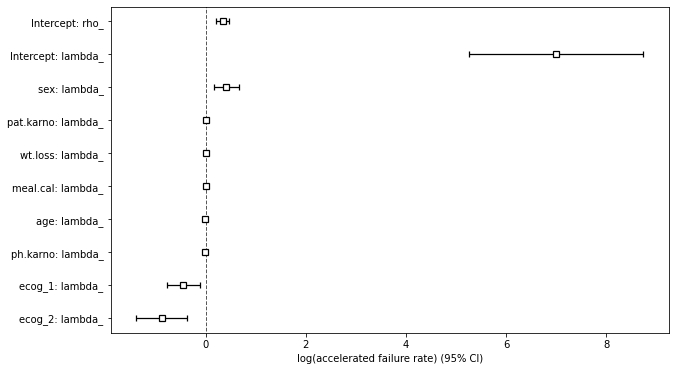

In [139]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot()

<AxesSubplot:>

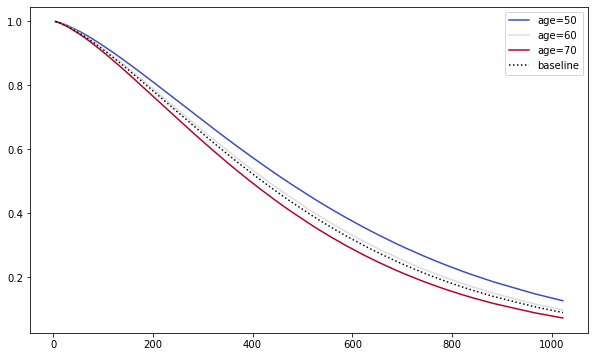

In [138]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot_partial_effects_on_outcome('age', range(50, 80, 10), cmap='coolwarm')